# Reproduction of kaggle first place

Based on:

https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266385

https://www.kaggle.com/code/ligtfeather/eca-nfnet-sam-opt-mixup-k-folds-w-b

First place solution architecture:

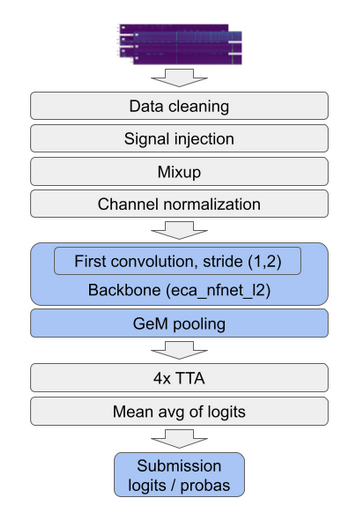

In [ ]:
# !pip install timm
# !pip install albumentations

In [2]:
import os
import random
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import timm
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from adamp import AdamP

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import wandb

In [3]:
config = {
    'num_workers': 4,
    'model': 'eca_nfnet_l0',
    'device': 'cuda',
    'batch_size': 50,
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'epochs': 5,
    'num_folds': 2
}

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(seed=config['seed'])

# Data Loading

In [5]:
train_data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_filepath = os.path.join(train_data_dir, '2000_balanced_labels.npy')

with open(labels_filepath, 'rb') as f:
    initial_data = np.load(f, allow_pickle=True)
    
initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

In [6]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2000 non-null   string
 1   target          2000 non-null   int32 
 2   image_filepath  2000 non-null   string
dtypes: int32(1), string(2)
memory usage: 39.2 KB


Split the data into 70% train and 30% test:

In [7]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

# Custom Dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = np.load(image_filepath).astype(np.float32)
        image = np.vstack(image).transpose((1, 0))
            
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        
        label = torch.tensor(self.targets[idx]).float()
        return image, label

# Image Augmentation

In [9]:
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'], config['image_size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightness(limit=0.6, p=0.5),
            albumentations.Cutout(
                num_holes=10, max_h_size=12, max_w_size=12,
                fill_value=0, always_apply=False, p=0.5
            ),
            albumentations.ShiftScaleRotate(
                shift_limit=0.25, scale_limit=0.1, rotate_limit=0
            ),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(config['image_size'],config['image_size']),
            ToTensorV2(p=1.0)
        ]
    )

def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(config['image_size'], config['image_size']),
                ToTensorV2(p=1.0)
            ]
        )

## Mixup

In [10]:
def mixup(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# Loss and ROC Monitoring

In [11]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )
    
def use_roc_score(output, target):
    try:
        y_pred = torch.sigmoid(output).cpu()
        y_pred = y_pred.detach().numpy()
        target = target.cpu()

        return roc_auc_score(target, y_pred)
    except:
        return 0.5

# Weight Random Sampler

In [12]:
def get_sampler(train_data):
    class_counts = train_data['target'].value_counts().to_list()
    num_samples = sum(class_counts)
    labels = train_data['target'].to_list()

    class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
    weights = [class_weights[labels[i]] for i in range(int(num_samples))]
    sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

# Train and Validation Dataloaders

In [13]:
def get_loaders(train_data, valid_data, sampler):
    training_set = CustomDataset(
        images_filepaths=train_data['image_filepath'].values,
        targets=train_data['target'].values,
        transform=get_train_transforms())

    validation_set = CustomDataset(
        images_filepaths=valid_data['image_filepath'].values,
        targets=valid_data['target'].values,
        transform=get_valid_transforms())

    train_loader = DataLoader(
        training_set,
        batch_size=config['batch_size'],
        shuffle=True,
        # num_workers=config['num_workers'],
        sampler = sampler,
        pin_memory=True)

    valid_loader = DataLoader(
        validation_set,
        batch_size=config['batch_size'],
        shuffle=False,
        # num_workers=config['num_workers'],
        pin_memory=True)
    
    return train_loader, valid_loader

# Model

In [14]:
class EcaNFNet(nn.Module):
    def __init__(self, model_name=config['model'], output_features=config['output_features'],
                 input_channels=config['input_channels'], pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained,
                                       in_chans=input_channels)
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, output_features, bias=True)    
    
    def forward(self, x):
        x = self.model(x)
        return x

# Sharpness Aware Minimisation (SAM) Optimiser

In [15]:
# https://www.kaggle.com/code/psb2024/cassavapytorcheffnettrain/notebook

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)
            
            def update_state(p):
                if p.grad is not None:
                    e_w = p.grad * scale.to(p)
                    p.add_(e_w)  # climb to the local maximum "w + e(w)"
                    self.state[p]["e_w"] = e_w
            
            map(update_state, group["params"])
            
#             for p in group["params"]:
#                 if p.grad is None: continue
#                 e_w = p.grad * scale.to(p)
#                 p.add_(e_w)  # climb to the local maximum "w + e(w)"
#                 self.state[p]["e_w"] = e_w
        if zero_grad: self.zero_grad()
    
    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            
            def update_p(p):
                if p.grad is not None:
                    p.sub_(self.state[p]["e_w"])
            
            map(update_p, group["params"])
            
#             for p in group["params"]:
#                 if p.grad is None: continue
#                 p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        stack = [torch.tensor(list(map(lambda p: p.grad.norm(p=2).to(shared_device), list(filter(lambda p: p.grad is not None, group["params"]))))) for group in self.param_groups]  # torch.tensor(list(map(lambda p: p.grad.norm(p=2).to(shared_device) if p.grad is not None else p, group["params"])))
        norm = torch.norm(torch.stack(stack), p=2)
        return norm

# Initialise Model, Loss Function, Optimizer and Scheduler

In [16]:
model = EcaNFNet()
model = model.to(config['device'])
criterion = nn.BCEWithLogitsLoss().to(config['device'])
base_optimizer = AdamP
optimizer = SAM(model.parameters(), base_optimizer, lr=config['lr'], weight_decay=config['weight_decay'])

scheduler = CosineAnnealingLR(optimizer,
                              T_max=config['T_max'],
                              eta_min=config['min_lr'],
                              last_epoch=-1)

# K-Fold CV

In [42]:
def train(train_loader, model, criterion, optimizer, epoch, params, scheduler):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(enumerate(train_loader), total=len(train_loader))
       
    for i, (images, target) in stream:
        images = images.to(config['device'])
        target = target.to(config['device']).float().view(-1, 1)
        # images, targets_a, targets_b, lam = mixup(images, target.view(-1, 1))
            
        output = model(images)
        # loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss = criterion(output, target)
        
        return images
                    
        loss.backward(retain_graph = True)
        optimizer.first_step(zero_grad=True)
        
        # mixup_criterion(criterion, model(images), targets_a, targets_b, lam).backward()
        criterion.backward()
        optimizer.second_step(zero_grad=True)      
        
        roc_score = use_roc_score(output, target)
        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('ROC', roc_score)
        wandb.log({"Train Epoch":epoch,"Train loss": loss.item(), "Train ROC":roc_score})

        stream.set_description(
            "Epoch: {epoch}. Train. {metric_monitor}".format(
                epoch=epoch,
                metric_monitor=metric_monitor))
    
    scheduler.step()

In [18]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(enumerate(val_loader), total=len(val_loader))
    final_targets = []
    final_outputs = []

    with torch.no_grad():
        for i, (images, target) in stream:
            images = images.to(config['device'], non_blocking=True)
            target = target.to(config['device'], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            roc_score = use_roc_score(output, target)
            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('ROC', roc_score)
            wandb.log({"Valid Epoch": epoch, "Valid loss": loss.item(), "Valid ROC":roc_score})
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(
                    epoch=epoch,
                    metric_monitor=metric_monitor)
            )
            
            targets = target.detach().cpu().numpy().tolist()
            outputs = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(outputs)

    return final_outputs, final_targets

# W&B Initialisation for K-Fold CV

**W&B API key**: 47b00b0f6291346fe94ab4a6dceca03a809fbf4a

In [45]:
best_roc = -np.inf
best_epoch = -np.inf
best_model_name = None
_images = None

kfold = StratifiedKFold(n_splits=config['num_folds'], shuffle=True, random_state=config['seed'])

for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_df, train_df['target'])):
    run = wandb.init(project='eca-NFNet-Mixup', 
             config=config, 
             group = 'ECA-NFNet',
             job_type='train',
             name = f'Fold{fold}')

    print(f"{'='*40} Fold: {fold} {'='*40}")

    train_data = train_df.iloc[trn_idx]
    valid_data = train_df.iloc[val_idx]
    
    sampler = get_sampler(train_data)
    
    train_loader, valid_loader = get_loaders(train_data, valid_data, sampler)

    for epoch in range(1, config['epochs'] + 1):
        _images = train(train_loader, model, criterion, optimizer, epoch, config, scheduler)
        
        break
        
        predictions, valid_targets = validate(valid_loader, model, criterion, epoch, config)
        
        roc_auc = round(roc_auc_score(valid_targets, predictions), 3)
        torch.save(model.state_dict(),f"{config['model']}_{epoch}_epoch_{roc_auc}_roc_auc.pth")

        if roc_auc > best_roc:
            best_roc = roc_auc
            best_epoch = epoch
            best_model_name = f"{config['model']}_{epoch}_epoch_{roc_auc}_roc_auc.pth"
            
    print(f"Best ROC-AUC in fold: {fold} was: {best_roc:.4f}")
    print(f"Final ROC-AUC in fold: {fold} was: {roc_auc:.4f}")

wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


C:\Users\adnan\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\adnan\anaconda3\lib\site-packages\albumentations\augmentations\dropout\cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


======================================== Fold: 0 ========================================


  0%|          | 0/15 [00:01<?, ?it/s]

Best ROC-AUC in fold: 0 was: -inf
Final ROC-AUC in fold: 0 was: 0.5320


wandb: wandb version 0.12.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


======================================== Fold: 1 ========================================


  0%|          | 0/15 [00:01<?, ?it/s]

Best ROC-AUC in fold: 1 was: -inf
Final ROC-AUC in fold: 1 was: 0.5320


In [46]:
_images

tensor([[[[-1.4280e-01, -2.6579e-01, -3.2157e-01,  ..., -3.3083e-01,
           -2.4634e-01, -7.9694e-02],
          [-8.7237e-02, -1.7940e-01, -2.7984e-01,  ..., -3.6012e-01,
           -4.5148e-01, -2.6057e-01],
          [-1.3292e-02, -8.2784e-02, -1.5286e-01,  ..., -3.8037e-01,
           -4.9212e-01, -4.2561e-01],
          ...,
          [-4.8009e-01, -2.8035e-01, -8.3338e-02,  ...,  2.3515e-01,
            1.4724e-01,  6.9831e-02],
          [-6.3959e-01, -3.2443e-01, -1.5432e-01,  ...,  2.1861e-02,
           -6.1654e-02,  1.1192e-01],
          [-5.4378e-01, -4.8327e-01, -3.5701e-01,  ...,  1.2821e-01,
           -2.2750e-02, -6.5614e-02]]],


        [[[-3.5780e+00, -2.6182e+00, -3.2473e+00,  ..., -1.2644e+00,
           -1.6192e+00, -1.2150e+00],
          [-2.3693e+00, -2.5110e+00, -2.3153e+00,  ..., -1.6807e+00,
           -1.5849e+00, -1.7599e+00],
          [-2.9828e+00, -2.5303e+00, -2.5692e+00,  ..., -1.9977e+00,
           -1.4258e+00, -1.1929e+00],
          ...,
   

# Manual Evaluation

In [ ]:
model = EcaNFNet() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('eca_nfnet_l0_9_epoch_0.593_roc_auc.pth'))
model.eval()

In [ ]:
train_loader, valid_loader = get_loaders(train_data, valid_data, sampler)

# prediction = model(np.load(train_df.iloc[0].image_filepath).astype(np.float32))

In [ ]:
sample_images = []
sample_labels = []
predictions = []

stream = tqdm(enumerate(valid_loader), total=len(valid_loader))
final_targets = []
final_outputs = []

with torch.no_grad():
    for i, (images, target) in stream:
        images = images.to('cpu', non_blocking=True)
        target = target.to('cpu', non_blocking=True).float().view(-1, 1)
        output = model(images)

In [39]:
len(_images[0])

1

IndexError: index 1 is out of bounds for dimension 0 with size 1

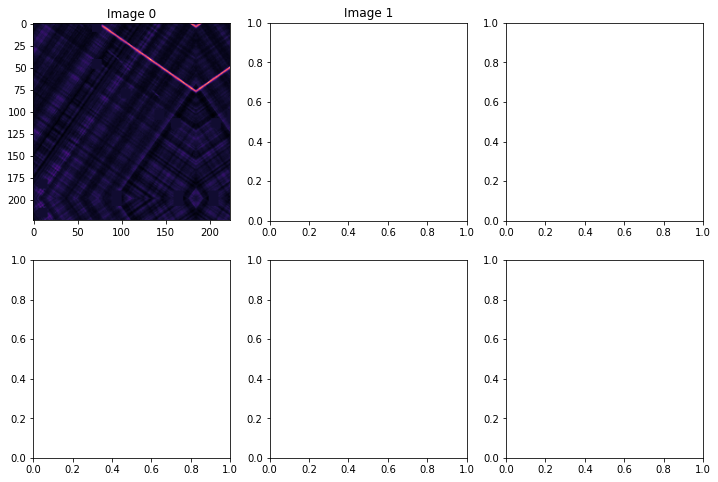

In [47]:
f, ax = plt.subplots(2,3, figsize=(12,8))
images = _images.cpu()
for i in range(len(images)):
    row = i // 3
    column = i - row * 3
    
    ax[row, column].set_title('Image ' + str(i))
    ax[row, column].imshow(images[0][i], cmap=plt.get_cmap('magma'))